In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('4.csv')
corr = data.corr()
msk = np.random.rand(len(data)) < 0.8
data.head()

target  age  educ  work_exp  interest  coffee  boss_educ  passport  green  \
0       0   50     4        27         8     1.3          1         0      2   
1       0   30     3        10         0     0.0          6         1      2   
2       0   43     3        22         7     1.9          6         1      1   
3       0   58     3        31         7     2.0          4         0      3   
4       1   40     3        23         7     0.0          6         1      3   

   floor  children  climate  offhour  dist  salary  heigh  lunch  
0      3         2        0        0  10.6       1    176    226  
1      3         0        0        0  11.5       0    186    226  
2      5         0        3        0  12.8       1    166    238  
3      3         1        1        0  15.2       1    180    216  
4      2         0        0        0  16.1       1    180    286

Уберём сильно скоррелированные признаки, так как они малоинформативны. Покажем выбранные признаки.

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics


columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

selected_columns = data.columns[columns]
data = data[selected_columns]

list(selected_columns)

['target',
 'age',
 'educ',
 'interest',
 'coffee',
 'boss_educ',
 'passport',
 'green',
 'floor',
 'children',
 'climate',
 'offhour',
 'dist',
 'salary',
 'heigh',
 'lunch']

Логистическая регрессия запускает регуляризацию, следовательно в результате обучения мы получим веса независимых переменных. Отбросим малозначимые признаки и покажем отобранные.

In [3]:
lr = make_pipeline(StandardScaler(), LogisticRegression(fit_intercept=False))
lr.fit(data[msk].drop('target', axis=1), data[msk]['target'])
selector = SelectFromModel(lr[-1], prefit=True)
xs = list(data.drop('target', axis=1).columns[selector.get_support()])
xs

['interest', 'coffee', 'climate', 'offhour', 'dist']

Переобучим нашу модель на отобранных признаках:

In [4]:
logreg = make_pipeline(StandardScaler(), LogisticRegression(fit_intercept=False))
logreg.fit(data[xs][msk], data[msk]['target'])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(fit_intercept=False))])

Проверим нашу модель на тестовой выборке. Выведем метрики $F1$, $ROC\_AUC$ и матрицу ошибок. 

In [5]:
lr_probs = logreg.predict_proba(data[~msk][xs])[:,1]
lr_preds = logreg.predict(data[xs][~msk])
lr_auc = metrics.roc_auc_score(data[~msk]['target'], lr_probs)
f1 = metrics.f1_score(data[~msk]['target'], lr_preds)
lr_fpr, lr_tpr, _ = metrics.roc_curve(data[~msk]['target'], lr_probs)
print(f'lr_auc={lr_auc}; f1={f1}')
metrics.confusion_matrix(data[~msk]['target'], lr_preds)

lr_auc=0.8047453703703704; f1=0.6459627329192548


array([[90, 45],
       [12, 52]])

Значения метрик $F1$, $ROC\_AUC$ свидетельствуют о приемлемой точности и полноте модели. Матрица ошибок показывает большое количество истинно положительных и истинно отрицательных случаеви, малое количество ложно отрицательных и ложно положительных случаев, что является приемлемым результатом.

Построим $ROC$-кривую.

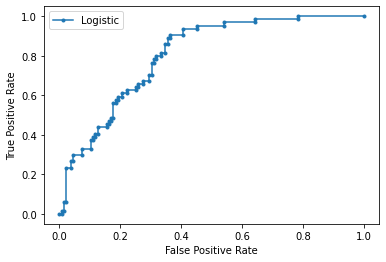

In [6]:
from matplotlib import pyplot as plt


plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Кривая выгибается наверх, что является показателем качества модели.